In [ ]:
!pip install -qqq transformers simpletransformers nltk stanza

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/IDK-MRC/dataset .

In [ ]:
import argparse
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import wandb
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [ ]:
DATA_DIR = "dataset/idk_mrc"

In [ ]:
with open(os.path.join(DATA_DIR, "train.json"), "r") as f:
    train = json.load(f)

with open(os.path.join(DATA_DIR, "valid.json"), "r") as f:
    valid = json.load(f)

with open(os.path.join(DATA_DIR, "test.json"), "r") as f:
    test = json.load(f)

In [ ]:
type(train)

list

In [ ]:
train[0]

{'context': 'Douwes Dekker terlahir di Pasuruan, Jawa Timur, pada tanggal 8 Oktober 1879, sebagaimana yang dia tulis pada riwayat hidup singkat saat mendaftar di Universitas Zurich, September 1913. Ayahnya, Auguste Henri Edoeard Douwes Dekker, adalah seorang agen di bank kelas kakap Nederlandsch Indisch Escomptobank. Auguste ayahnya, memiliki darah Belanda dari ayahnya, Jan (adik Eduard Douwes Dekker) dan dari ibunya, Louise Bousquet. Sementara itu, ibu Douwes Dekker, Louisa Neumann, lahir di Pekalongan, Jawa Tengah, dari pasangan Jerman-Jawa.[1] Dia terlahir sebagai anak ke-3 dari 4 bersaudara, dan keluarganya pun sering berpindah-pindah. Saudaranya yang perempuan dan laki-laki, yakni Adeline (1876) dan Julius (1878) terlahir sewaktu keluarga Dekker berada di Surabaya, dan adik laki-lakinya lahir di Meester Cornelis, Batavia (sekarang Jatinegara, Jakarta Timur pada tahun 1883. Dari situ, keluarga Dekker berpindah lagi ke Pegangsaan, Jakarta Pusat.[1]',
 'qas': [{'id': 'indonesian-1653

In [ ]:
train_flatten = []
for sample in train:
    context = sample['context']
    for qas in sample['qas']:
        qas.update({'context': context})
        train_flatten.append(qas)

In [ ]:
valid_flatten = []
for sample in valid:
    context = sample['context']
    for qas in sample['qas']:
        qas.update({'context': context})
        valid_flatten.append(qas)

In [ ]:
test_flatten = []
for sample in test:
    context = sample['context']
    for qas in sample['qas']:
        qas.update({'context': context})
        test_flatten.append(qas)

In [ ]:
len(train_flatten)

9332

In [ ]:
d_train = pd.DataFrame(train_flatten)
d_valid = pd.DataFrame(valid_flatten)
d_test = pd.DataFrame(test_flatten)

In [ ]:
d_train.head()

,id,is_impossible,question,answers,context
0,indonesian-1653118927826418646-2,False,dimanakah Dr. Ernest François Eugène Douwes D...,"[{'text': 'Pasuruan, Jawa Timur', 'answer_star...","Douwes Dekker terlahir di Pasuruan, Jawa Timur..."
1,indonesian-2988585593205955820-unans-h-2,True,di manakah Dr. Ernest François Eugène Douwes ...,[],"Douwes Dekker terlahir di Pasuruan, Jawa Timur..."
2,indonesian--6681782391154035358-9,False,Kapan PBB mulai terbentuk ?,"[{'text': '24 Oktober 1945', 'answer_start': 3...",Sebagai tindak lanjut Atlantic Charter tersebu...
3,indonesian-7178095139251802211-unans-h-2,True,Kapan PBB dibubarkan?,[],Sebagai tindak lanjut Atlantic Charter tersebu...
4,indonesian--7923158717065963850-0,False,Siapakah pendiri PBB?,"[{'text': '51 negara anggota', 'answer_start':...","Perserikatan Bangsa-Bangsa (PBB, English: Unit..."


In [ ]:
d_valid.head()

,id,is_impossible,question,answers,context
0,indonesian-455106851360971978-0,False,Apa kepanjangan dari GPS?,"[{'text': 'Global Positioning System', 'answer...",Sistem Pemosisi Global [1] (bahasa Inggris: Gl...
1,indonesian--1312965901076079633-5,False,Apakah Cabang ilmu pengetahuan alam yang mempe...,"[{'text': 'herpetologi', 'answer_start': 250}]","Ukuran reptil bervariasi, dari yang berukuran ..."
2,indonesian--1312965901076079633-5-unans-m-1,True,Apa Cabang ilmu pengetahuan alam yang tidak me...,[],"Ukuran reptil bervariasi, dari yang berukuran ..."
3,indonesian-7819026179506588734-0,False,Apakah maksud reptil dalam bahasa Latin?,"[{'text': ''melata' atau 'merayap'', 'answer_s...","Reptil (binatang melata, atau dalam bahasa Lat..."
4,indonesian-5582359985109511611-unans-h-2,True,Apakah maksud reptil ganas dalam bahasa Latin?,[],"Reptil (binatang melata, atau dalam bahasa Lat..."


In [ ]:
d_test.head()

,id,is_impossible,question,answers,context
0,indonesian--5104646170401738836-2,False,Kapan Komputer mikro mulai dikembangkan ?,"[{'text': '1959', 'answer_start': 194}]",Ada beberapa inovasi dari GAN yang sedikit nga...
1,indonesian-6216827355594812160-unans-h-2,True,Kapan komputer mikro mulai ditinggalkan?,[],Ada beberapa inovasi dari GAN yang sedikit nga...
2,indonesian-6528297441097904801-unans-h-2,True,Kapan Komputer mikro mulai dikembangkan Amerik...,[],Ada beberapa inovasi dari GAN yang sedikit nga...
3,indonesian-8272224502256244072-unans-h-2,True,Kapan Komputer makro mulai dikembangkan?,[],Ada beberapa inovasi dari GAN yang sedikit nga...
4,indonesian-2447946428908350610-0,False,Apakah pengertian matronimik?,[{'text': 'Komomene sebuah nama yang berdasark...,"Patronim, atau patronimik, adalah sebuah kompo..."


In [ ]:
d_train['answers_text'] = d_train.answers.apply(lambda x: x[0]['text'] if len(x) else None)
d_valid['answers_text'] = d_valid.answers.apply(lambda x: x[0]['text'] if len(x) else None)
d_test['answers_text'] = d_test.answers.apply(lambda x: x[0]['text'] if len(x) else None)

In [ ]:
d_train.question

0       dimanakah  Dr. Ernest François Eugène Douwes D...
1       di manakah  Dr. Ernest François Eugène Douwes ...
2                             Kapan PBB mulai terbentuk ?
3                                   Kapan PBB dibubarkan?
4                                   Siapakah pendiri PBB?
                              ...                        
9327    Apa sebutan untuk posisi Matahari yang statis ...
9328    Manusia perlu menyimpan dan membawa data-data ...
9329    berapakah jumlah dialek bahasa Sunda yang tida...
9330    berapakah jumlah dialek bahasa Sunda yang disa...
9331              Kapan orangtua Kim Dae-jung dilahirkan?
Name: question, Length: 9332, dtype: object

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
model = AutoModel.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.embeddings

XLMRobertaEmbeddings(
  (word_embeddings): Embedding(250002, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
embedding_weight = model.embeddings.word_embeddings.weight
position_weight = model.embeddings.position_embeddings.weight

In [ ]:
embedding_weight.shape

torch.Size([250002, 768])

In [ ]:
d_train.loc[0, 'question']

'dimanakah  Dr. Ernest François Eugène Douwes Dekker dilahirkan?'

In [ ]:
d_train.loc[9330, 'question']

'berapakah jumlah dialek bahasa Sunda yang disamakan oleh para ahli?'

In [ ]:
question_token_1 = tokenizer.encode(d_train.loc[0, 'question'])
question_token_2 = tokenizer.encode(d_train.loc[9330, 'question'])

In [ ]:
print(question_token_1)
print(question_token_2)

[0, 29423, 6577, 1773, 5, 101985, 115065, 5177, 134725, 984, 36648, 7, 262, 6850, 190543, 32, 2]
[0, 770, 180546, 19836, 879, 5663, 16639, 96155, 119, 6392, 54082, 1628, 121, 16154, 32, 2]


In [ ]:
token_pos_1 = torch.arange(len(question_token_1))
token_pos_2 = torch.arange(len(question_token_2))

In [ ]:
question_weight_1 = embedding_weight[question_token_1, :] + position_weight[token_pos_1, :]
question_weight_2 = embedding_weight[question_token_2, :] + position_weight[token_pos_2, :]

In [ ]:
question_weight_1

tensor([[ 0.2208,  0.1436,  0.1536,  ...,  0.1413,  0.1600,  0.0382],
        [ 0.2537,  0.0410, -0.0977,  ...,  0.2385,  0.3938,  0.3076],
        [-0.0950, -0.0718, -0.3661,  ..., -0.0674, -0.3646,  0.1179],
        ...,
        [ 0.2345,  0.0535, -0.0596,  ...,  0.2443, -0.0395, -0.2419],
        [ 0.0591,  0.2560,  0.0218,  ...,  0.2730, -0.0263,  0.3835],
        [ 0.1938,  0.2835,  0.1067,  ...,  0.1169, -0.0145,  0.1633]],
       grad_fn=<AddBackward0>)

In [ ]:
question_weight_2.sum()

tensor(391.3256, grad_fn=<SumBackward0>)

In [ ]:
q_weight_mean_1 = question_weight_1.sum(axis=0)
q_weight_mean_2 = question_weight_2.sum(axis=0)

In [ ]:
q_weight_mean_1 = q_weight_mean_1.unsqueeze(dim=0)
q_weight_mean_2 = q_weight_mean_2.unsqueeze(dim=0)

In [ ]:
torch.nn.functional.cosine_similarity(q_weight_mean_1, q_weight_mean_2)

tensor([0.8828], grad_fn=<SumBackward1>)

In [ ]:
def get_embedding(question):
    token = tokenizer.encode(question)
    weight = embedding_weight[token, :]
    mean_weight = weight.mean(dim=0)

    return mean_weight

In [ ]:
train_embedding = torch.zeros(len(d_train), 768)
for idx, question in enumerate(d_train.question):
    q_embed = get_embedding(question)
    train_embedding[idx, :] = q_embed

In [ ]:
test_embedding = torch.zeros(len(d_test), 768)
for idx, question in enumerate(d_test.question):
    q_embed = get_embedding(question)
    test_embedding[idx, :] = q_embed

In [ ]:
train_embedding.shape

torch.Size([9332, 768])

In [ ]:
test_embedding.shape

torch.Size([844, 768])

In [ ]:
all_embed = torch.concat((train_embedding, test_embedding), dim=0)

In [ ]:
all_embed.shape

torch.Size([10176, 768])

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_model = PCA(n_components=2)

In [ ]:
pca_model.fit(all_embed.detach().numpy())

PCA(n_components=2)

In [ ]:
train_pca = pca_model.transform(train_embedding.detach().numpy())

In [ ]:
train_pca.shape

(9332, 2)

In [ ]:
test_pca = pca_model.transform(test_embedding.detach().numpy())

In [ ]:
train_pca[0]

array([-0.42300907, -0.00902689], dtype=float32)

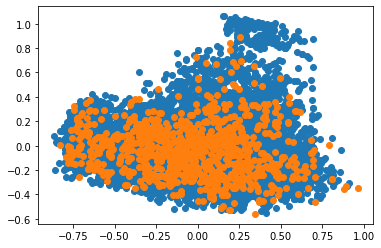

In [ ]:
plt.scatter(x=train_pca[:,0], y=train_pca[:,1])
plt.scatter(x=test_pca[:,0], y=test_pca[:,1])

In [ ]:
train_embedding

tensor([[ 0.1177,  0.0598,  0.1033,  ...,  0.1197, -0.0255,  0.1829],
        [ 0.1151,  0.0820,  0.1135,  ...,  0.1003, -0.0397,  0.2041],
        [ 0.1254,  0.1803, -0.0210,  ...,  0.1767,  0.0847,  0.1980],
        ...,
        [ 0.1489,  0.1083,  0.0368,  ...,  0.0958,  0.0255,  0.1435],
        [ 0.1451,  0.1024,  0.0423,  ...,  0.0979,  0.0091,  0.1378],
        [ 0.1681,  0.1086,  0.1004,  ...,  0.1933,  0.0435,  0.1709]],
       grad_fn=<CopySlices>)

In [ ]:
test_embedding

tensor([[ 0.1897,  0.1891, -0.0401,  ...,  0.1693,  0.0755,  0.2107],
        [ 0.1787,  0.1772, -0.0534,  ...,  0.1302,  0.0511,  0.2094],
        [ 0.1720,  0.1731, -0.0399,  ...,  0.1633,  0.0554,  0.1790],
        ...,
        [ 0.1093,  0.1641, -0.0216,  ...,  0.1181,  0.0366,  0.1445],
        [ 0.0940,  0.1978,  0.0383,  ...,  0.1517,  0.0756,  0.1808],
        [ 0.0869,  0.1975,  0.0438,  ...,  0.1572,  0.0623,  0.1774]],
       grad_fn=<CopySlices>)

In [ ]:
cosine_score = torch.nn.functional.cosine_similarity(test_embedding[0].unsqueeze(dim=0), train_embedding)

In [ ]:
cosine_score

tensor([0.8794, 0.8774, 0.9472,  ..., 0.8904, 0.8899, 0.9072],
       grad_fn=<SumBackward1>)

In [ ]:
cosine_score.min()

tensor(0.8315, grad_fn=<MinBackward1>)

In [ ]:
cosine_score.max()

tensor(0.9549, grad_fn=<MaxBackward1>)

In [ ]:
cosine_score.mean()

tensor(0.8863, grad_fn=<MeanBackward0>)

In [ ]:
d_test.loc[0, 'question']

'Kapan Komputer mikro mulai dikembangkan ?'

In [ ]:
d_test.loc[0, 'answers_text']

'1959'

In [ ]:
cosine_score.argmax()

tensor(5488)

In [ ]:
d_train.loc[5488,'question']

'Kapan komputer diciptakan ?'

In [ ]:
d_train.loc[5488,'answers_text']

'1941'